In [20]:
!uv pip install fitparse tqdm numpy matplotlib pillow maturin
# !uv pip install gpxpy==1.6.2 fitdecode==0.10.0 pandas==1.5.3 --no-cache-dir
# !uv pip install fit2gpx==1.0.0 --no-cache-dir
! cd ./rust && maturin develop --release

Using Python 3.10.6 environment at: /Users/jackstanley/venv/jupyter
Audited 6 packages in 15ms
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /Users/jackstanley/venv/jupyter/bin/python
   Compiling fitcoords v0.1.0 (/Users/jackstanley/Documents/VSCode/heatmap_art/rust)
    Finished `release` profile [optimized] target(s) in 1.77s                 
📦 Built wheel for CPython 3.10 to /var/folders/7t/85nd7c414hn3h2_f8lp409br0000gn/T/.tmpDPJd7d/fitcoords-0.1.0-cp310-cp310-macosx_11_0_arm64.whl
✏️ Setting installed package as editable
🛠 Installed fitcoords-0.1.0


### Unzip export directory and all .fit files

In [21]:
import os
import gzip
from tqdm import tqdm

zip = None
for file in os.listdir():
    if file.endswith('.zip'):
        zip = file
        break
if zip is None:
    raise Exception('No zip file found')
unzipped = zip.replace('.zip', '')
if os.path.exists(unzipped):
    print(f'Found existing {unzipped}')
else:
    print(f'Unzipping {zip}')
    os.system(f'unzip {zip} -d {unzipped}')

activities_dir = os.path.join(unzipped, 'activities')
if not os.path.exists(activities_dir):
    raise Exception('No activities folder found')
print(f'Unzipping {len(os.listdir(activities_dir))} directories')
activity_paths = []
for filename in tqdm(os.listdir(activities_dir)):
    if filename.endswith('.fit.gz'):
        filepath = os.path.join(activities_dir, filename)
        output_filepath = os.path.join(activities_dir, filename[:-3]) # Remove .gz extension
        try:
            with gzip.open(filepath, 'rb') as f_in:
                with open(output_filepath, 'wb') as f_out:
                    f_out.writelines(f_in)
                    activity_paths.append(output_filepath)
        except Exception as e:
            print(f"Error extracting {filename}: {e}")
    elif filename.endswith('.gpx'):
        activity_paths.append(os.path.join(activities_dir, filename))

Found existing export_59042520
Unzipping 3113 directories


100%|██████████| 3113/3113 [00:01<00:00, 1768.78it/s]


### Convert .fit files to .gpx

In [22]:
# from fit2gpx import Converter

# conv = Converter()
# conv.fit_to_gpx_bulk(dir_in='./activities', dir_out='./activities_gpx')

In [23]:
import numpy as np
from fitparse import FitFile
import gpxpy
import pickle
import fitcoords as fc

def semicircles_to_degrees(lat_sc, lon_sc):
    """
    Convert Garmin semicircle format to degrees
    """
    lat = lat_sc * (180 / 2**31)
    lon = lon_sc * (180 / 2**31)
    return lat, lon

def parse_fit_file(fit_file):
    fitfile = FitFile(activity_path, check_crc=False)
    for record in fitfile.get_messages('record'):
        lat = record.get_value('position_lat')
        lon = record.get_value('position_long')
        if lat is None or lon is None:
            continue
        lat, lon = semicircles_to_degrees(lat, lon)
        ele = record.get_value('enhanced_altitude')
        coords.append((lat, lon, ele))

def parse_fit_file_fast(fit_file):
    coords.append(fc.parse_fit_to_numpy(fit_file))

def parse_gpx_file(coords, gpx_file):
    gpx_file = open(gpx_file, 'r')
    gpx = gpxpy.parse(gpx_file)
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                coords.append((point.latitude, point.longitude)) #, point.elevation))

if os.path.exists('coords.pkl'):
    with open('coords.pkl', 'rb') as file:
        coords = pickle.load(file)
    print(f'Loaded {len(coords)} coordinates from pickle file')
else:
    coords = fc.parse_fit_dir_to_numpy(activities_dir)
    # handle gpx files
    for activity_path in tqdm(activity_paths):
        gpx_coords = []
        if activity_path.endswith('.gpx'):
            parse_gpx_file(gpx_coords, activity_path)
            gpx_coords = np.array(gpx_coords)
            coords = np.concatenate((coords, np.array(gpx_coords)))
    import pickle 
    with open('coords.pkl', 'wb') as f:
        pickle.dump(coords, f)

    print(f'Loaded {len(coords)} coordinates')


Loaded 1440116 coordinates from pickle file


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import math

def get_rect(ul_coord, miles):
    ul_lat, ul_lon = ul_coord
    
    miles_per_deg_lat = 69.0
    miles_per_deg_lon = 69.0 * math.cos(math.radians(ul_lat))
    
    delta_lat = miles / miles_per_deg_lat
    delta_lon = miles / miles_per_deg_lon
    
    lr_lat = ul_lat - delta_lat
    lr_lon = ul_lon + delta_lon
    
    return (ul_coord, (lr_lat, lr_lon))


# tuple of (upper-left-tuple, bottom-right-tuple)
# princeton = ((40.415217, -74.797882), (40.282776, -74.548656))
princeton = get_rect((40.430217, -74.767882), 12)
boulder = get_rect((40.111741, -105.365283), 20)
boulder2 = get_rect((40.167741, -105.650283), 30) # includes mags
duke = get_rect((36.031007, -79.014064), 7)
mendham = get_rect((40.896692, -74.845338), 25)
mendham2 = get_rect((40.886692, -74.715338), 15)
parkcity = get_rect((40.748435, -111.570050), 10)
us = get_rect((49.921607, -126.647587), 3000)

bounds = princeton

folder = 'princeton'
if folder is not None:
    os.makedirs(folder, exist_ok=True)
ul_lat, ul_lon = bounds[0]
br_lat, br_lon = bounds[1]

in_bounds = lambda x: x[0] < bounds[0][0] and x[0] >= bounds[1][0] and \
            x[1] > bounds[0][1] and x[1] <= bounds[1][1]
filtered_coords = filter(in_bounds, coords)

width, height = 2048, 2048
img_array = np.zeros((width, height))
img_gauss = np.zeros((width, height))

def latlon_to_pixel(lat, lon):
    """
    Convert lat/lon to pixel coordinates in the image.
    Y axis is top-to-bottom (latitude decreases downward)
    X axis is left-to-right (longitude increases rightward)
    """
    x = int((lon - ul_lon) / (br_lon - ul_lon) * width)
    y = int((ul_lat - lat) / (ul_lat - br_lat) * height)
    # Clamp to image bounds
    x = max(0, min(width - 1, x))
    y = max(0, min(height - 1, y))
    return x, y

# pre-calculate gaussian
sigma = 1
size = sigma * 3
x = np.arange(-size, size)
y = np.arange(-size, size)
xv, yv = np.meshgrid(x, y)
gaussian = np.exp(-(xv**2 + yv**2) / (2*sigma**2))

def add_gaussian(img, x0, y0, sigma=5):
    """
    Add a 2D Gaussian centered at (x0, y0) to the image array
    """
    x_min = max(0, x0 - size)
    x_max = min(width, x0 + size)
    y_min = max(0, y0 - size)
    y_max = min(height, y0 + size)

    gx_min = x_min - (x0 - size)
    gx_max = gx_min + (x_max - x_min)
    gy_min = y_min - (y0 - size)
    gy_max = gy_min + (y_max - y_min)

    img[y_min:y_max, x_min:x_max] += gaussian[gy_min:gy_max, gx_min:gx_max]

# img_array = np.zeros((20, 20))
# add_gaussian(img_array, 5, 5)

# # Add all coordinates
for lat, lon in tqdm(list(filtered_coords)):  # coords in semicircles
    x, y = latlon_to_pixel(lat, lon)
    add_gaussian(img_gauss, x, y, sigma=1)
    img_array[int(y), int(x)] += 1

100%|██████████| 469291/469291 [00:01<00:00, 327571.91it/s]


### Clip to 255

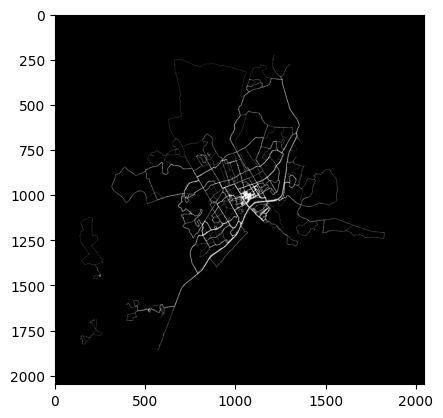

In [25]:
clipped = np.clip(img_array * 255, 0, 255).astype(np.uint8)
plt.imshow(clipped, cmap='gray')
plt.show()
img = Image.fromarray(clipped)
if folder is not None:
    img.save(f'{folder}/clip255.png')

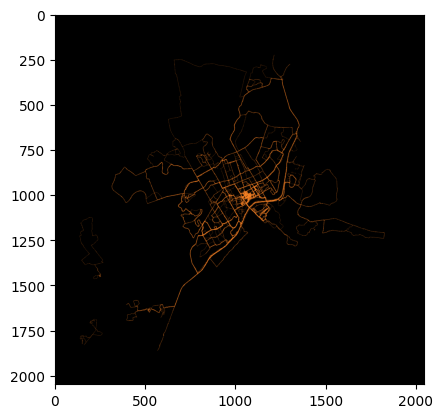

In [26]:
color = np.repeat(clipped[:, :, np.newaxis], 3, axis=2)
color[np.sum(color, axis=2) > 1, :] = np.array([(245, 128, 36)])
plt.imshow(color)
plt.show()
img = Image.fromarray(color)
if folder is not None:
    img.save(f'{folder}/color.png')

### Clip with gaussian

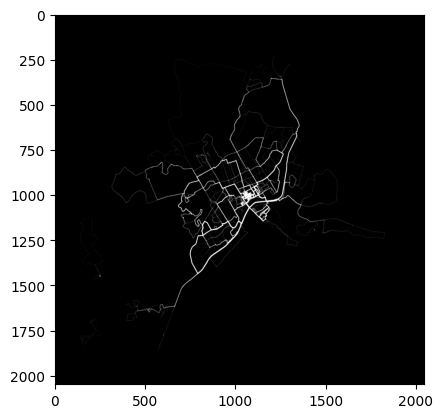

In [27]:
clipped_gauss = np.clip(img_gauss * 10, 0, 255).astype(np.uint8)
plt.imshow(clipped_gauss, cmap='gray')
plt.show()
img = Image.fromarray(clipped_gauss)
if folder is not None:
    img.save(f'{folder}/clip_gauss.png')

### Gradients

(512, 3)


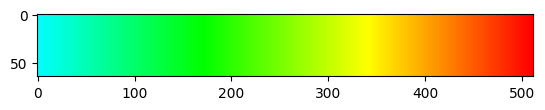

In [28]:
import importlib
import gradient
importlib.reload(gradient)
g = gradient.Gradient.temp()
sample = g.sample()

plt.imshow(sample)

Use gradient where each the brightness is weighted by the fifth-root of the initial weight

Done


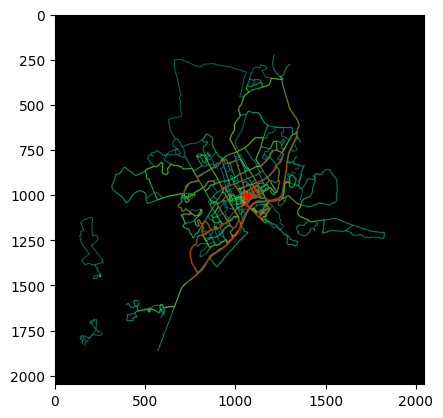

In [29]:
def draw_grad_black(data, gradient, filename=None):
    # data is 0-255
    img = gradient.eval_np(data / 255, weight=lambda x: np.power(x, 1/5))
    print("Done")
    # make sure the gradient is black at 0
    g.stops.insert(1, 0.001)
    g.colors.insert(0, (0,0,0))
    plt.imshow(img)
    img = Image.fromarray(img)
    if filename is not None:
        img.save(filename)

f = None
if folder is not None:
    f = f'{folder}/black-temp.png'
draw_grad_black(clipped_gauss, g, f)

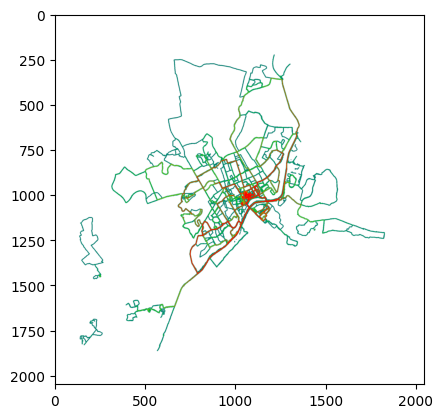

In [30]:
def white_weighting(x):
    ones = x == 1
    x = np.power(1-x, 1/5)
    x[ones] = 1
    return x

def draw_grad_white(data, gradient, filename=None):
    # data is 0-255
    g_white = reversed(gradient)
    # make sure the gradient is white at 1
    g_white.stops.insert(-1, 0.999)
    g_white.colors.append((255,255,255))
    img = g_white.eval_np((255 - data) / 255, weight=white_weighting)
    plt.imshow(img)
    img = Image.fromarray(img)
    if filename is not None:
        img.save(filename)

f = None
if folder is not None:
    f = f'{folder}/white-temp.png'
draw_grad_white(clipped_gauss, g, f)


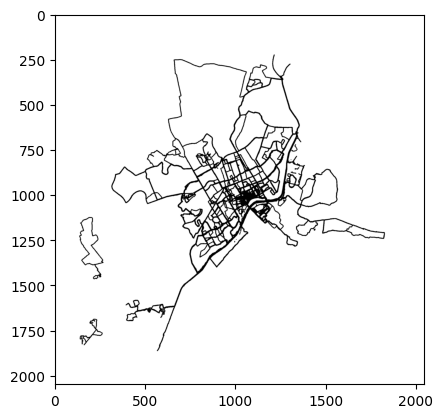

In [31]:
f = None
if folder is not None:
    f = f'{folder}/black-on-white.png'
draw_grad_white(clipped_gauss, gradient.Gradient([[0,0,0], [0,0,0]]), f)